In [1]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
import theano.tensor as tt

starry.config.lazy = True
starry.config.quiet = True

In [2]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1120_1330).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1120_1330).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

In [3]:
def mean_data(Phase, Flux, Error, bins):

    Phase_split = np.array_split(Phase, bins)
    Flux_split = np.array_split(Flux, bins)
    Error_split = np.array_split(Error, bins)

    meanPhase = [] * bins
    meanFlux = [] * bins
    meanError = [] * bins

    for i in range(bins):

        meanPhase_i = np.mean(Phase_split[i])
        meanFlux_i = np.sum(Flux_split[i] / (Error_split[i]**2))/ np.sum(1/(Error_split[i]**2))

        meanError_i = np.sqrt(1/np.sum(1/(Error_split[i]**2)))

        meanPhase.append(meanPhase_i)
        meanFlux.append(meanFlux_i)
        meanError.append(meanError_i)
        
    return meanPhase, meanFlux, meanError

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

In [4]:
FUV_flux = meanFlux
FUV_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

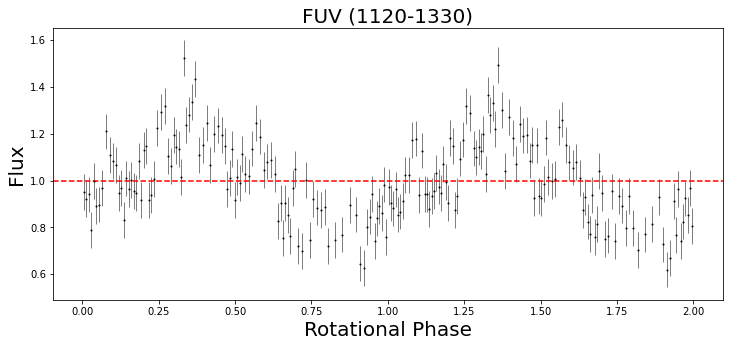

In [5]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1120-1330)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV_flux, yerr=FUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

# 25 Degrees

In [18]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = 1
    radius = 25
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [19]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat]


message: Optimization terminated successfully.
logp: -18.12991593684792 -> 286.006118230801


In [20]:
keys = ["lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
lat          46.20614
lon          58.22629
inc          43.29551


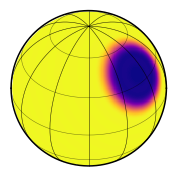

In [6]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=1, radius=25, lat=36.85098, lon=50.29432)
map.inc = 52.95406
map.show()

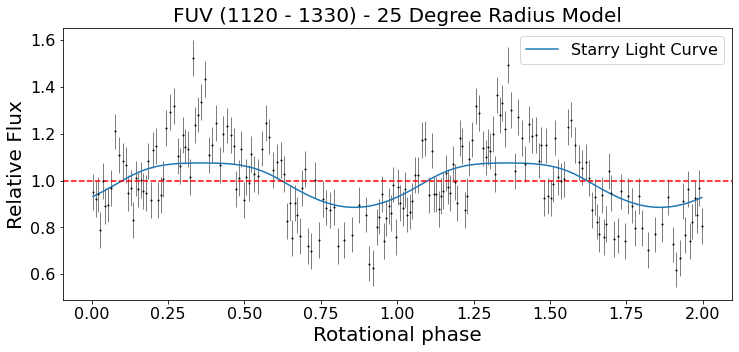

In [9]:
FUV_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1120 - 1330) - 25 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend(fontsize=16)
plt.ylabel("Relative Flux", fontsize=20)
plt.errorbar(meanPhase, FUV_flux, yerr=FUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axhline(y=1, color='r', linestyle='--');

# 30 Degrees

In [6]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = 1
    radius = 30
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [7]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat]


message: Optimization terminated successfully.
logp: -191.12273234920767 -> 79.0537276319929


In [8]:
keys = ["lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
lat          37.91973
lon          51.04817
inc          51.85643


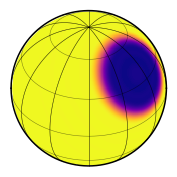

In [6]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=1, radius=30, lat=37.91973, lon=51.04817)
map.inc = 51.85643
map.show()

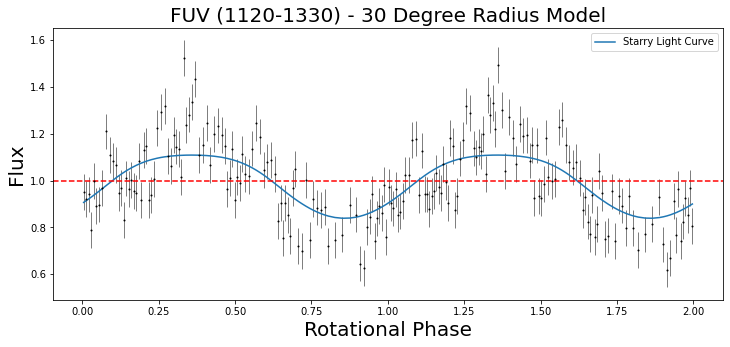

In [7]:
FUV_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1120-1330) - 30 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV_flux, yerr=FUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

# 35 Degrees

In [17]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 35
    lat = 50.64638
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 39.35362
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [18]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -88.74256797643997 -> 93.40643306943822


In [19]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.99196
lon          50.38877


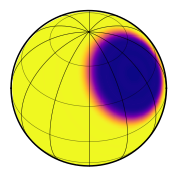

In [14]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=1, radius=35, lat=43.01930, lon=51.20670)
map.inc = 46.52323
map.show()

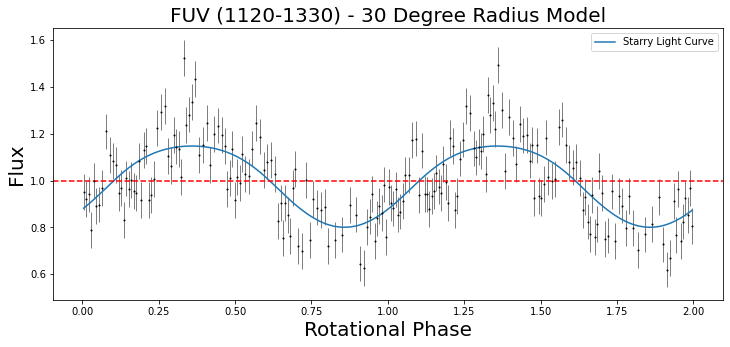

In [15]:
FUV_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1120-1330) - 30 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV_flux, yerr=FUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

# 40 Degrees

In [19]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = 1
    radius = 40
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [20]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat]


message: Optimization terminated successfully.
logp: -190.80210515252023 -> 108.83699619058079


In [21]:
keys = ["lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
lat          52.26037
lon          50.82444
inc          36.65145


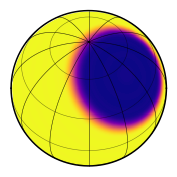

In [6]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=1, radius=40, lat=52.26037, lon=50.82444)
map.inc = 36.65145
map.show()

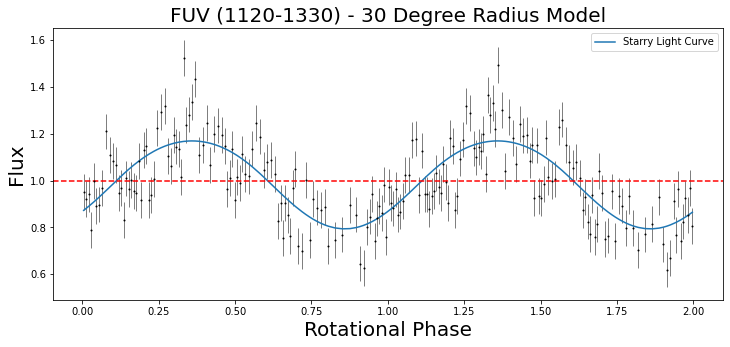

In [7]:
FUV_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1120-1330) - 30 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV_flux, yerr=FUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

# 45 Degrees

In [32]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 45
    lat = 60.37420
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 29.62580
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [33]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -85.65936529941649 -> 109.04588081534587


In [34]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.98045
lon          50.62477


# 50 Degrees

In [29]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 50
    lat = 65.36171
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.63829
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [30]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -91.1679477120131 -> 110.01851249958874


In [31]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.98053
lon          50.64799


# 55 Degrees

In [44]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 55
    lat = 69.52247
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 20.47753
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [45]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -99.11808520220467 -> 110.41666068298203


In [46]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.98230
lon          50.66913


# 60 Degrees

In [65]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 60
    lat = 72.76113
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 17.23887
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [66]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -107.59110581945306 -> 111.0168981613266


In [67]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.97833
lon          50.70195


# 60 Degrees - Part 2

In [56]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = 1
    radius = 60
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [57]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat]


message: Optimization terminated successfully.
logp: -189.95404614943712 -> 110.7943611142942


In [58]:
keys = ["lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
lat          72.69607
lon          50.73772
inc          16.24385


# 65 Degrees

In [80]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 65
    lat = 74.39755
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 15.60245
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [81]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -110.36325245257089 -> 111.87720137618518


In [82]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.94479
lon          50.75678
